# CS6700: Reinforcement Learning
## Programming Assignment 1

Submitted by:
- Archish S (ME20B032)
- Vinayak Gupta (EE20B152)

# Imports

## Libraries

In [3]:
import numpy as np
from math import floor
import matplotlib.pyplot as plt
import seaborn as sns

import tqdm

In [4]:
num_rows = 10
num_columns = 10
start_state = {
    "s1": np.array([[0, 4]]),
    "s2": np.array([[3, 6]]),
}
obstructions = np.array([[0, 7], [1, 1], [1, 2], [1, 3], [1, 7], [2, 1], [2, 3],
                        [2, 7], [3, 1], [3, 3], [3, 5], [4, 3], [4, 5], [4, 7],
                        [5, 3], [5, 7], [5, 9], [6, 3], [6, 9], [7, 1], [7, 6],
                        [7, 7], [7, 8], [7, 9], [8, 1], [8, 5], [8, 6], [9, 1]])

bad_states = np.array([[1, 9], [4, 2], [4, 4], [7, 5], [9, 9]])
restart_states = np.array([[3, 7], [8, 2]])
goal_states = np.array([[0, 9], [2, 2], [8, 7]])

step_reward = -1
goal_reward = 10
bad_state_reward = -6
restart_state_reward = -100

p_good_transition = 1
bias = 0.5

## Environment Definition

In [5]:
class BaseEnv:
    
    def step(self, state, action):
        raise NotImplementedError
    
    def reset(self):
        raise NotImplementedError

In [6]:
class GridWorld(BaseEnv):
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind=False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward=None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = GridWorld.row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = GridWorld.row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = GridWorld.row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = GridWorld.row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states, self.num_states, self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):

                # check if the state is the goal state or an obstructed state - transition to end
                row_col = GridWorld.seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1, 2, 1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col), 1)==0):
                        next_state = GridWorld.row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state, :, :] = 0
                        self.P[state, next_state, :] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2, 3, 1, 0]
        right = [3, 2, 0, 1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1, 1, 0, 0]
        col_change = [0, 0, -1, 1]
        row_col = GridWorld.seq_to_col_row(state, self.num_cols)
        row_col[0, 0] += row_change[direction]
        row_col[0, 1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:, 0] > self.num_rows-1) or
                np.any(row_col[:, 1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = GridWorld.row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:, 0] > self.num_rows-1) or
                np.any(row_col[:, 1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = GridWorld.row_col_to_seq(row_col, self.num_cols)[0]

        return next_state
    
    def plot(self):
        """
        Plots the gridworld with the start, goal, and bad states.
        Mark X for Obstructions, G for Goal, B for Bad, and S for Start
        """
        grid = np.zeros((self.num_rows, self.num_cols))
        if self.obs_states is not None:
            for i in range(self.obs_states.shape[0]):
                grid[self.obs_states[i, 0], self.obs_states[i, 1]] = -1
        for i in range(self.goal_states.shape[0]):
            grid[self.goal_states[i, 0], self.goal_states[i, 1]] = 1
        for i in range(self.bad_states.shape[0]):
            grid[self.bad_states[i, 0], self.bad_states[i, 1]] = -2
        for i in range(self.restart_states.shape[0]):
            grid[self.restart_states[i, 0], self.restart_states[i, 1]] = -3
        grid[self.start_state[0, 0], self.start_state[0, 1]] = 2
        sns.heatmap(grid, annot=False, cmap="coolwarm", cbar=False, linewidths=0.5, linecolor='black')
        plt.gca().set_aspect('equal', adjustable='box')

        for i in range(self.num_rows):
            for j in range(self.num_cols):
                if grid[i, j] == 1:
                    plt.text(j+0.5, i+0.5, 'G', ha='center', va='center', fontsize=10)
                if grid[i, j] == -2:
                    plt.text(j+0.5, i+0.5, 'B', ha='center', va='center', fontsize=10)
                if grid[i, j] == -3:
                    plt.text(j+0.5, i+0.5, 'R', ha='center', va='center', fontsize=10)
                if grid[i, j] == 2:
                    plt.text(j+0.5, i+0.5, 'S', ha='center', va='center', fontsize=10)
                if grid[i, j] == -1:
                    plt.text(j+0.5, i+0.5, 'X', ha='center', va='center', fontsize=10)


    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if (self.wind and np.random.random() < 0.4):
            arr = self.P[next_state, :, 3]
            next_next = np.where(arr == np.amax(arr))
            next_next = next_next[0][0]
            return next_next, self.R[next_next]
        else:
            return next_state, self.R[next_state]

    @staticmethod
    def row_col_to_seq(row_col, num_cols):
        #Converts state number to row_column format
        return row_col[:, 0] * num_cols + row_col[:, 1]

    @staticmethod
    def seq_to_col_row(seq, num_cols): 
        #Converts row_column format to state number
        r = floor(seq / num_cols)
        c = seq - r * num_cols
        return np.array([[r, c]])

In [7]:
def get_env(state, wind=False, p_good_transition=1.0):
    gw = GridWorld(
        num_rows=num_rows,
        num_cols=num_columns,
        start_state=start_state[state],
        goal_states=goal_states,
        wind=wind
    )
    gw.add_obstructions(
        obstructed_states=obstructions,
        bad_states=bad_states,
        restart_states=restart_states
    )
    gw.add_transition_probability(
        p_good_transition=p_good_transition,
        bias=bias
    )
    gw.add_rewards(
        step_reward=step_reward,
        goal_reward=goal_reward,
        bad_state_reward=bad_state_reward,
        restart_state_reward=restart_state_reward
    )
    env = gw.create_gridworld()
    return env

# Policy

## Action Policy Definitions

In [8]:
class BasePolicy:
    @property
    def name(self):
        raise NotImplementedError

    def select_action(self, state, action_values):
        raise NotImplementedError

### Greedy Policy

In [9]:
class GreedyPolicy(BasePolicy):
    @property
    def name(self):
        return 'greedy'

    def __init__(self, actions):
        self.actions = actions

    def select_action(self, state, action_values):
        return self.actions[np.argmax(action_values[state, :])]

### $\varepsilon$-Greedy Policy

The $\varepsilon$-greedy policy defined as
$$
\textrm{next\_action} = \begin{cases}
    \underset{a \in A(s)}{\arg\max} \; Q(s, a) & \text{with probability } 1 - \varepsilon \\
    \textrm{random choice} & \text{with probability } \varepsilon
\end{cases}
$$

Hyperparameters:
- $\varepsilon$: The probability of choosing a random action

In [10]:
class EpGreedyPolicy(BasePolicy):
    @property
    def name(self):
        return f'ep-greedy ep:{self.epsilon}'

    def __init__(self, epsilon, actions):
        self.epsilon = epsilon
        self.actions = actions

    def select_action(self, state, action_values):

        if np.random.binomial(1, 1-self.epsilon):
            return self.actions[np.argmax(action_values[state, :])]
        else:
            return np.random.choice(self.actions)

### Softmax Policy

The softmax policy is defined as
$$
\textrm{next\_action} = \begin{cases}
    a_1 & \text{with probability } \mathcal{P}(1) \\
    a_2 & \text{with probability } \mathcal{P}(2) \\
    \vdots  & \vdots \\
    a_n & \text{with probability } \mathcal{P}(n)
\end{cases}
$$
where 
$$
\mathcal{P}(a) = \dfrac{e^{Q(s, a) / \tau}}{\sum\limits_{i=1}^{n} e^{Q(s, i) / \tau}}
$$

Hyperparameters:
- $\tau$: The temperature parameter

In [11]:
from scipy.special import softmax

class SoftmaxPolicy(BasePolicy):
    @property
    def name(self):
        return f'softmax tau:{self.tau}'

    def __init__(self, tau, actions):
        self.tau = tau
        self.actions = actions

    def select_action(self, state, action_values):
        return np.random.choice(self.actions, p = softmax(action_values[state, :]/self.tau))

## Update Policy Definitions

In [12]:
class BaseUpdate:
    @property
    def name(self):
        raise NotImplementedError
    
    def update(self, state):
        raise NotImplementedError

### SARSA

The update rule for SARSA:
$$
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)]
$$

Hyperparameters:
- $\alpha$: The learning rate
- $\gamma$: The discount factor


In [13]:
class SARSAUpdate(BaseUpdate):
    @property
    def name(self):
        return 'sarsa'

    def __init__(self, alpha, gamma):
        self.alpha = alpha
        self.gamma = gamma

    def update(self, Q, state, action, next_state, next_action, reward):
        return Q[state, action] + self.alpha * (reward + self.gamma * Q[next_state, next_action] - Q[state, action])

### Q-Learning

The update rule for Q-Learning:
$$
Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma \max_{a} Q(s_{t+1}, a) - Q(s_t, a_t)]
$$

Hyperparameters:
- $\alpha$: The learning rate
- $\gamma$: The discount factor

In [14]:
class QLearningUpdate(BaseUpdate):
    @property
    def name(self):
        return 'q-learning'

    def __init__(self, alpha, gamma):
        self.alpha = alpha
        self.gamma = gamma

    def update(self, Q, state, action, next_state, next_action, reward):
        return Q[state, action] + self.alpha * (reward + self.gamma * np.max(Q[next_state, :]) - Q[state, action])

## Policy Iterators

In [15]:
class PolicyTrainer:
    def __init__(self, env, exploration_policy, update_policy, episodes, runs):
        self.env = env
        self.exploration_policy = exploration_policy
        self.update_policy = update_policy
        self.episodes = episodes
        self.runs = runs

        self.steps = np.zeros((runs, episodes))
        self.rewards = np.zeros((runs, episodes))
        self.Q = np.zeros((runs, env.num_states, env.num_actions))
        self.hmap_visits = np.zeros((runs, env.num_states))
        self.hmap_Q = np.zeros((runs, env.num_states))

    def train(self):
        np.random.seed(32+152)

        for run in tqdm.trange(self.runs, desc='Training Runs'):
            for episode in range(self.episodes):

                current_state = GridWorld.row_col_to_seq(self.env.start_state, self.env.num_cols)[0]
                current_action = self.exploration_policy.select_action(current_state, self.Q[run])

                self.steps[run, episode] = 0
                self.rewards[run, episode] = 0
                self.hmap_visits[run, current_state] += 1

                while current_state not in GridWorld.row_col_to_seq(self.env.goal_states, self.env.num_cols) and self.steps[run, episode] < 100:

                    next_state, reward = self.env.step(current_state, current_action)
                    next_action = self.exploration_policy.select_action(next_state, self.Q[run])

                    self.Q[run, current_state, current_action] = self.update_policy.update(self.Q[run], current_state, current_action, next_state, next_action, reward)

                    if current_state != next_state:
                        self.hmap_visits[run, next_state] += 1

                    current_state = next_state
                    current_action = next_action

                    self.steps[run, episode] += 1
                    self.rewards[run, episode] += reward

                if current_state not in list(GridWorld.row_col_to_seq(self.env.goal_states, self.env.num_cols)):
                    self.steps[run, episode] = np.inf

            for state in range(self.env.num_states):
                self.hmap_Q[run, state] = np.max(self.Q[run, state, :])

    def plot_policy(self):
        Q = np.mean(self.Q, axis=0)

        start_state = '_s1' if (self.env.start_state == np.array([0, 4])).all() else '_s2'
        wind_state = '_windy' if self.env.wind else '_clear'
        name = self.update_policy.name + start_state + wind_state + self.exploration_policy.name + '_policy.jpg'

        policy = GreedyPolicy(np.arange(self.env.num_actions))
        hmap_visits = np.zeros(self.env.num_states)
        hmap_visits[GridWorld.row_col_to_seq(self.env.start_state, self.env.num_cols)] = 1

        current_state = GridWorld.row_col_to_seq(self.env.start_state, self.env.num_cols)[0]
        current_action = policy.select_action(current_state, Q)

        steps = 0
        rewards = 0

        
        path = [current_state]
        while current_state not in GridWorld.row_col_to_seq(self.env.goal_states, self.env.num_cols) and steps < 100:
                
                next_state, reward = self.env.step(current_state, current_action)
                next_action = policy.select_action(next_state, Q)
    
                hmap_visits[next_state] = 1
    
                current_state = next_state
                current_action = next_action
    
                steps += 1
                rewards += reward
                path.append(current_state)

        plt.title("Learnt Policy")
        # hmap = sns.heatmap(hmap_visits.reshape(self.env.num_rows, self.env.num_cols), annot=False)
        self.env.plot()
        plt.plot([x % self.env.num_cols + 0.5 for x in path], [x // self.env.num_cols + 0.5 for x in path], 'r--')
        plt.savefig('plots/' + name, pad_inches=0.1, bbox_inches='tight')

    def plot_reward(self):

        start_state = '_s1' if (self.env.start_state == np.array([0, 4])).all() else '_s2'
        wind_state = '_windy' if self.env.wind else '_clear'
        name = self.update_policy.name + start_state + wind_state + self.exploration_policy.name + '_reward.jpg'
    
        plt.title(f"Reward per Episode: Avg:{round(np.mean(self.rewards), 3)}, Max:{round(np.max(self.rewards), 3)}")

        plt.plot(self.rewards.mean(axis=0), 'r')
        plt.fill_between(range(self.episodes), self.rewards.mean(axis=0) - self.rewards.std(axis=0), self.rewards.mean(axis=0) + self.rewards.std(axis=0), alpha=0.2, color='r')

        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.savefig('plots/' + name, pad_inches=0.1, bbox_inches='tight')
        
    def plot_steps(self):

        start_state = '_s1' if (self.env.start_state == np.array([0, 4])).all() else '_s2'
        wind_state = '_windy' if self.env.wind else '_clear'
        name = self.update_policy.name + start_state + wind_state + self.exploration_policy.name + '_steps.jpg'

        plt.title(f"Steps per Episode: Avg:{round(np.mean(self.steps), 3)}, Max:{round(np.max(self.steps), 3)}, Min:{round(np.min(self.steps), 3)}")
        
        plt.plot(self.steps.mean(axis=0), 'b')
        plt.fill_between(range(self.episodes), self.steps.mean(axis=0) - self.steps.std(axis=0), self.steps.mean(axis=0) + self.steps.std(axis=0), alpha=0.2, color='b')

        plt.xlabel('Episodes')
        plt.ylabel('Steps')
        plt.savefig('plots/' + name, pad_inches=0.1, bbox_inches='tight')

    def plot_visits(self):

        start_state = '_s1' if (self.env.start_state == np.array([0, 4])).all() else '_s2'
        wind_state = '_windy' if self.env.wind else '_clear'
        name = self.update_policy.name + start_state + wind_state + self.exploration_policy.name + '_heatmap.jpg'

        plt.title("State Visits")
        hmap_visits = np.mean(self.hmap_visits, axis=0)
        hmap = sns.heatmap(hmap_visits.reshape(self.env.num_rows, self.env.num_cols), annot=False)
        plt.savefig('plots/' + name, pad_inches=0.1, bbox_inches='tight')

    def plot_Q(self):

        start_state = '_s1' if (self.env.start_state == np.array([0, 4])).all() else '_s2'
        wind_state = '_windy' if self.env.wind else '_clear'
        name = self.update_policy.name + start_state + wind_state + self.exploration_policy.name + '_Q.jpg'

        plt.title(f"State Value Function: Avg:{round(np.mean(self.hmap_Q), 3)}, Max:{round(np.max(self.hmap_Q), 3)}, Min:{round(np.min(self.hmap_Q), 3)}")
        Q = np.mean(self.hmap_Q, axis=0)
        hmap = sns.heatmap(Q.reshape(self.env.num_rows, self.env.num_cols), annot=False)
        plt.savefig('plots/' + name, pad_inches=0.1, bbox_inches='tight')

---

# Hyperparameter Tuning

To conduct hyperparameter tuning, we opt for maximizing asymptotic optimality, which entails leveraging Q-values acquired by the agent and employing a greedy action selection method. 

Following this approach, we establish a grid search function to determine the optimal hyperparameter set based on asymptotic optimality.

In [16]:
def reward_grid_search(env, alphas, gammas, epsilons, taus, model = 'sarsa', policy = 'epsilon'):
    optimal_reward = - np.inf
    optimal_hyperparams = {}

    if policy == "softmax":
    # Softmax
        for gamma in gammas:
            for alpha in alphas:
                for tau in taus:
                    print(f"The current set of Hyperparams: alpha = {alpha}, gamma = {gamma}, tau = {tau}")
                    if model == "sarsa":
                        update_policy = SARSAUpdate(alpha=alpha, gamma=gamma)
                    elif model == "qlearning":
                        update_policy = QLearningUpdate(alpha=alpha, gamma=gamma)
        
                    exploration_policy = SoftmaxPolicy(tau=tau, actions=np.arange(env.num_actions))
                    trainer = PolicyTrainer(env, exploration_policy, update_policy, episodes=10000, runs=5)
                    trainer.train()
                    reward = trainer.rewards
                    mean_reward = np.mean(np.mean(reward, axis = 1), axis = 0)
                    if optimal_reward < mean_reward:
                        optimal_reward = mean_reward
                        optimal_hyperparams = {}
                        optimal_hyperparams["alpha"] = alpha
                        optimal_hyperparams["gamma"] = gamma
                        optimal_hyperparams["tau"] = tau
    
    elif policy == "epsilon":
    # Epsilon
        for gamma in gammas:
            for alpha in alphas:
                for epsilon in epsilons:
                    print(f"The current set of Hyperparams: alpha = {alpha}, gamma = {gamma}, epsilon = {epsilon}")
                    if model == "sarsa":
                        update_policy = SARSAUpdate(alpha=alpha, gamma=gamma)
                    elif model == "qlearning":
                        update_policy = QLearningUpdate(alpha=alpha, gamma=gamma)
                        
                    exploration_policy = EpGreedyPolicy(epsilon=epsilon, actions=np.arange(env.num_actions))
                    trainer = PolicyTrainer(env, exploration_policy, update_policy, episodes=10000, runs=5)
                    trainer.train()
                    reward = trainer.rewards
                    mean_reward = np.mean(np.mean(reward, axis = 1), axis = 0)
                    if optimal_reward < mean_reward:
                        optimal_reward = mean_reward
                        optimal_hyperparams = {}
                        optimal_hyperparams["alpha"] = alpha
                        optimal_hyperparams["gamma"] = gamma
                        optimal_hyperparams["epsilon"] = epsilons

    return optimal_hyperparams

$\alpha$: 0.001, 0.01, 0.1, 0.2

$\gamma$: 0.7, 0.8, 0.9, 1

$\epsilon$:  0.001, 0.01, 0.1, 0.5

$\tau$: 0.01, 0.1, 1, 2

In [17]:
alphas = [0.001, 0.01, 0.1, 0.2]
gammas = [0.7, 0.8, 0.9, 1]
epsilons = [0.001, 0.01, 0.1, 0.5]
tau = [0.01, 0.1, 1, 2]

### Experiment 1

State = s1 (0, 4) 
Wind = False 
p = 1 
SARSA Algo 



In [19]:
env = get_env('s1', wind=False, p_good_transition=1.0)
optimal_hyperparams = reward_grid_search(env, alphas, gammas, epsilons, tau, model="sarsa")
if "tau" in list(optimal_hyperparams.keys()):
    # Softmax is Best
    exploration_policy = SoftmaxPolicy(tau=optimal_hyperparams["tau"], actions=np.arange(env.num_actions))
elif "epsilon" in list(optimal_hyperparams.keys()):
    # Epsilon Greedy is Best
    exploration_policy = EpGreedyPolicy(epsilon=optimal_hyperparams["epsilon"], actions=np.arange(env.num_actions))
update_policy = SARSAUpdate(alpha=optimal_hyperparams["alpha"], gamma=optimal_hyperparams["gamma"])
trainer = PolicyTrainer(env, exploration_policy, update_policy, episodes=10000, runs=5)
trainer.train()

# Plotting 
trainer.plot_reward()
trainer.plot_steps()
trainer.plot_visits()
trainer.plot_Q()
trainer.plot_policy()

The current set of Hyperparams: alpha = 0.001, gamma = 0.7, tau = 0.01


Training Runs:   0%|          | 0/5 [00:00<?, ?it/s]/var/folders/vn/q3t9y55d35v26w9jqv0sf6p40000gn/T/ipykernel_1246/317266452.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.Q[run, current_state, current_action] = self.update_policy.update(self.Q[run], current_state, current_action, next_state, next_action, reward)
/var/folders/vn/q3t9y55d35v26w9jqv0sf6p40000gn/T/ipykernel_1246/317266452.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.rewards[run, episode] += reward
Training Runs: 100%|██████████| 5/5 [02:10<00:00, 26.07s/it]


The current set of Hyperparams: alpha = 0.001, gamma = 0.7, tau = 0.1


Training Runs: 100%|██████████| 5/5 [02:16<00:00, 27.21s/it]


The current set of Hyperparams: alpha = 0.001, gamma = 0.7, tau = 1


Training Runs: 100%|██████████| 5/5 [02:21<00:00, 28.24s/it]


The current set of Hyperparams: alpha = 0.001, gamma = 0.7, tau = 2


Training Runs: 100%|██████████| 5/5 [02:19<00:00, 27.96s/it]


The current set of Hyperparams: alpha = 0.01, gamma = 0.7, tau = 0.01


Training Runs: 100%|██████████| 5/5 [00:49<00:00,  9.86s/it]


The current set of Hyperparams: alpha = 0.01, gamma = 0.7, tau = 0.1


Training Runs: 100%|██████████| 5/5 [01:30<00:00, 18.17s/it]


The current set of Hyperparams: alpha = 0.01, gamma = 0.7, tau = 1


Training Runs: 100%|██████████| 5/5 [02:14<00:00, 26.80s/it]


The current set of Hyperparams: alpha = 0.01, gamma = 0.7, tau = 2


Training Runs: 100%|██████████| 5/5 [02:16<00:00, 27.25s/it]


The current set of Hyperparams: alpha = 0.1, gamma = 0.7, tau = 0.01


Training Runs: 100%|██████████| 5/5 [00:32<00:00,  6.51s/it]


The current set of Hyperparams: alpha = 0.1, gamma = 0.7, tau = 0.1


Training Runs: 100%|██████████| 5/5 [01:18<00:00, 15.69s/it]


The current set of Hyperparams: alpha = 0.1, gamma = 0.7, tau = 1


Training Runs: 100%|██████████| 5/5 [02:03<00:00, 24.68s/it]


The current set of Hyperparams: alpha = 0.1, gamma = 0.7, tau = 2


Training Runs: 100%|██████████| 5/5 [08:56<00:00, 107.28s/it]


The current set of Hyperparams: alpha = 0.2, gamma = 0.7, tau = 0.01


Training Runs: 100%|██████████| 5/5 [57:46<00:00, 693.30s/it] 


The current set of Hyperparams: alpha = 0.2, gamma = 0.7, tau = 0.1


Training Runs:   0%|          | 0/5 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [14]:
# env = get_env('s1', wind=False)
# exploration_policy = SoftmaxPolicy(tau=0.0001, actions=np.arange(env.num_actions))
# update_policy = SARSAUpdate(alpha=0.1, gamma=0.8)
# trainer = PolicyTrainer(env, exploration_policy, update_policy, episodes=10000, runs=5)
# trainer.train()

Training Runs:   0%|          | 0/5 [00:00<?, ?it/s]/var/folders/vn/q3t9y55d35v26w9jqv0sf6p40000gn/T/ipykernel_2051/317266452.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.Q[run, current_state, current_action] = self.update_policy.update(self.Q[run], current_state, current_action, next_state, next_action, reward)
/var/folders/vn/q3t9y55d35v26w9jqv0sf6p40000gn/T/ipykernel_2051/317266452.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.rewards[run, episode] += reward
Training Runs: 100%|██████████| 5/5 [00:31<00:00,  6.27s/it]


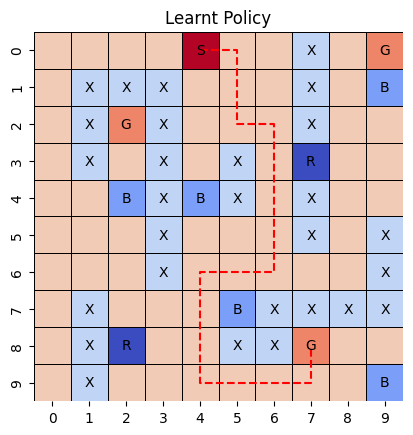

In [16]:
# trainer.plot_reward()
# trainer.plot_steps()
# trainer.plot_visits()
# trainer.plot_Q()
trainer.plot_policy()